# Convolutional AutoEncoder
Keywords :
1. Keras **subclass api**
2. Use of **Conv2DTranspose** (transpos conv. or deconv.)
2. Scatter plot of embeddings
3. Image generation from embedding

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, Layer, MaxPool2D, Conv2DTranspose
from tensorflow.keras import Model
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab

## A. Data Loading and Plotting

In [2]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fmnist.load_data()
train_num, h, w = x_train.shape
print(x_train.shape)
x_train, x_test = x_train[...,tf.newaxis]/255.0 - 0.5, x_test[...,tf.newaxis]/255.0 - 0.5

(60000, 28, 28)


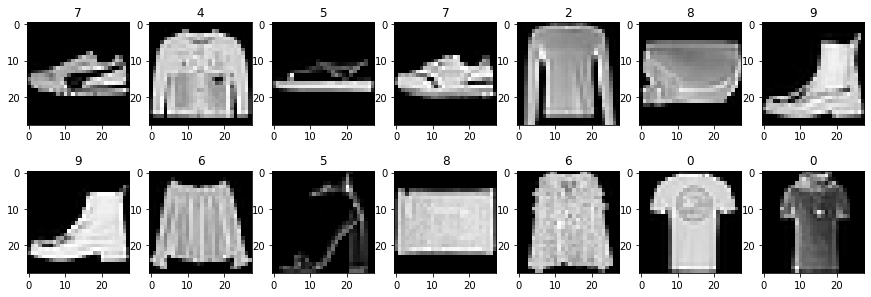

In [3]:
plt.figure(figsize=(15,5))
for i in np.arange(2*7):
    random_idx = np.random.randint(0,x_train.shape[0])
    plt.subplot(2,7,i+1)
    plt.imshow(x_train[random_idx].reshape(28,28),cmap='gray')
    plt.title(y_train[random_idx])

### Use `tf.data` to batch and shuffle the dataset:

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

## B. Model Construction with Keras Subclass API

In [5]:
embedding_dim = 2
n_classes = len(np.unique(y_train))
fc_input_dim = h*w

In [6]:
class ConvEncoder(Model):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        self.conv1 = Conv2D(32, 3, padding='same', activation='relu')
        self.pool1 = MaxPool2D(pool_size=(2, 2), padding='valid')
        self.conv2 = Conv2D(128, 3, padding='same', activation='relu')
        self.pool2 = MaxPool2D(pool_size=(2, 2), padding='valid')
        self.flatten = Flatten()
        self.emb = Dense(embedding_dim, activation=None)
    def call(self, x):
        x = self.conv1(x)
        print('shape after conv1 = ',x.shape)
        x = self.pool1(x)
        print('shape after pool1 = ',x.shape)
        x = self.conv2(x)
        print('shape after conv2 = ',x.shape)
        x = self.pool2(x)
        print('shape after pool2 = ',x.shape)
        x = self.flatten(x)
        emb = self.emb(x)
        print('shape emb = ',emb.shape)
        return emb


```python
conv_encoder_model = ConvEncoder()
conv_encoder_model.build(input_shape=(None,h,w,1))
conv_encoder_model.summary()
```

In [7]:
class ConvDecoder(Model):
    def __init__(self):
        super(ConvDecoder, self).__init__()
        self.d1 = Dense(7*7*128, activation='relu')
        self.reshape = Reshape(target_shape=(7,7,128))
        self.deconv1 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', strides=(2, 2), activation='relu')
        self.deconv2 = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=(2, 2), activation='relu')
        self.rec = Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="same")

    def call(self, x):
        x = self.d1(x)
        print('shape after d1 = ',x.shape)
        x = self.reshape(x)
        print('shape after reshape = ',x.shape)
        x = self.deconv1(x)
        print('shape after deconv1 = ',x.shape)
        x = self.deconv2(x)
        print('shape after deconv2 = ',x.shape)
        rec = self.rec(x)
        print('shape rec = ',x.shape)
        print(rec.shape)
        return rec


```python
conv_decoder_model = ConvDecoder()
conv_decoder_model.build(input_shape=(None,embedding_dim))
conv_decoder_model.summary()
```

In [8]:
# class ConvAutoEncoder(Model):
#     def __init__(self):
#         super(ConvAutoEncoder, self).__init__()
#         self.conv_encoder_model = ConvEncoder()
#         self.conv_decoder_model = ConvDecoder()
#     def call(self, x):
#         x = self.conv_encoder_model(x)
#         x = self.conv_decoder_model(x)
#         return x
        
encodeModel = ConvEncoder()
decodeModel = ConvDecoder()

## C. Train

In [9]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [10]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        embs = encodeModel(images, training=True)
        img_recs = decodeModel(embs, training=True)
        loss = loss_object(images,img_recs)
    trainable_variables = encodeModel.trainable_variables + decodeModel.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    train_loss(loss)

In [11]:
@tf.function
def find_emb_step(images):
    embs = encodeModel(images, training=False)
    return embs
@tf.function
def find_rec_step(embs):
    recs = decodeModel(embs, training=False)
    return recs

In [12]:
EPOCHS = 15
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    for images, labels in train_ds:
        train_step(images)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch+1, train_loss.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

shape after conv1 =  (32, 28, 28, 32)
shape after pool1 =  (32, 14, 14, 32)
shape after conv2 =  (32, 14, 14, 128)
shape after pool2 =  (32, 7, 7, 128)
shape emb =  (32, 2)
shape after d1 =  (32, 6272)
shape after reshape =  (32, 7, 7, 128)
shape after deconv1 =  (32, 14, 14, 128)
shape after deconv2 =  (32, 28, 28, 32)
shape rec =  (32, 28, 28, 32)
(32, 28, 28, 1)
shape after conv1 =  (32, 28, 28, 32)
shape after pool1 =  (32, 14, 14, 32)
shape after conv2 =  (32, 14, 14, 128)
shape after pool2 =  (32,

In [13]:
encodeModel.summary()
decodeModel.summary()

Model: "conv_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36992     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  12546     
Total params: 49,858
Trainable params: 49,858
Non-trainable params: 0
_________________________________________________________________
Model: "conv_decoder"
_________________________________________________________________
Layer (type)                

In [14]:
print('encodeModel Layers are:')
_ = [print(l.name) for l in encodeModel.layers]
print('\nencodeModel Variables are:')
_ = [print(var.name, var.shape, var.device) for var in encodeModel.variables]

print('\ndencodeModel Layers are:')
_ = [print(l.name) for l in decodeModel.layers]
print('\ndecodeModel Variables are:')
_ = [print(var.name, var.shape, var.device) for var in decodeModel.variables]

encodeModel Layers are:
conv2d
max_pooling2d
conv2d_1
flatten
dense

encodeModel Variables are:
conv_encoder/conv2d/kernel:0 (3, 3, 1, 32) /job:localhost/replica:0/task:0/device:GPU:0
conv_encoder/conv2d/bias:0 (32,) /job:localhost/replica:0/task:0/device:GPU:0
conv_encoder/conv2d_1/kernel:0 (3, 3, 32, 128) /job:localhost/replica:0/task:0/device:GPU:0
conv_encoder/conv2d_1/bias:0 (128,) /job:localhost/replica:0/task:0/device:GPU:0
conv_encoder/dense/kernel:0 (6272, 2) /job:localhost/replica:0/task:0/device:GPU:0
conv_encoder/dense/bias:0 (2,) /job:localhost/replica:0/task:0/device:GPU:0

dencodeModel Layers are:
dense_1
reshape
conv2d_transpose
conv2d_transpose_1
conv2d_transpose_2

decodeModel Variables are:
conv_decoder/dense_1/kernel:0 (2, 6272) /job:localhost/replica:0/task:0/device:GPU:0
conv_decoder/dense_1/bias:0 (6272,) /job:localhost/replica:0/task:0/device:GPU:0
conv_decoder/conv2d_transpose/kernel:0 (3, 3, 128, 128) /job:localhost/replica:0/task:0/device:GPU:0
conv_decoder/c

## D. Plot Embeddings

In [15]:
# dot colors
cmap=list()
for i in np.arange(n_classes):
    cmap.append(np.random.rand(1,3))
print(cmap[0])
permute_idx = np.random.permutation(n_classes)
cmap = [cmap[i] for i in permute_idx]

[[0.90693352 0.57562502 0.81814481]]


shape after conv1 =  (1200, 28, 28, 32)
shape after pool1 =  (1200, 14, 14, 32)
shape after conv2 =  (1200, 14, 14, 128)
shape after pool2 =  (1200, 7, 7, 128)
shape emb =  (1200, 2)


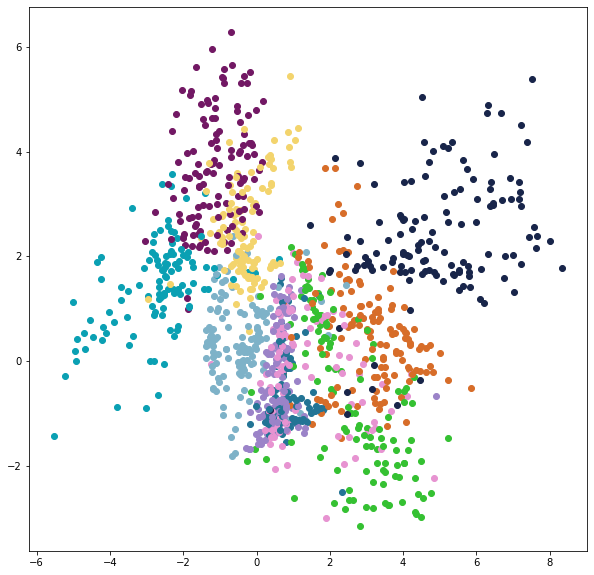

In [16]:
scatter_x = x_train[::50]
scatter_y = y_train[::50]
embeddings = encodeModel(scatter_x)
embeddings = embeddings.numpy()
img_num = len(scatter_x)
pylab.figure(figsize=(10,10))
for i in np.arange(0,img_num):
    x, y = (embeddings[i,0],embeddings[i,1])
    pylab.scatter(x,y,c=cmap[scatter_y[i]])
    #pylab.scatter(x,y,c=[[1,1,1]])
    #pylab.annotate(str(labels[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()

## E. Do Image Generation by Decoder

In [17]:
codes = list()
for xdim in np.arange(-2,2,0.2):
    for ydim in np.arange(-2,2,0.2):
        codes.append([xdim,ydim])
codes = tf.constant(codes,dtype=tf.float64)
print(codes.shape)
sampled_img = decodeModel(codes)

(400, 2)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

shape after d1 =  (400, 6272)
shape after reshape =  (400, 7, 7, 128)
shape after deconv1 =  (400, 14, 14, 128)
shape after deconv2 =  (400, 28, 28, 32)
shape rec =  (400, 28, 28, 32)
(400, 28, 28, 1)


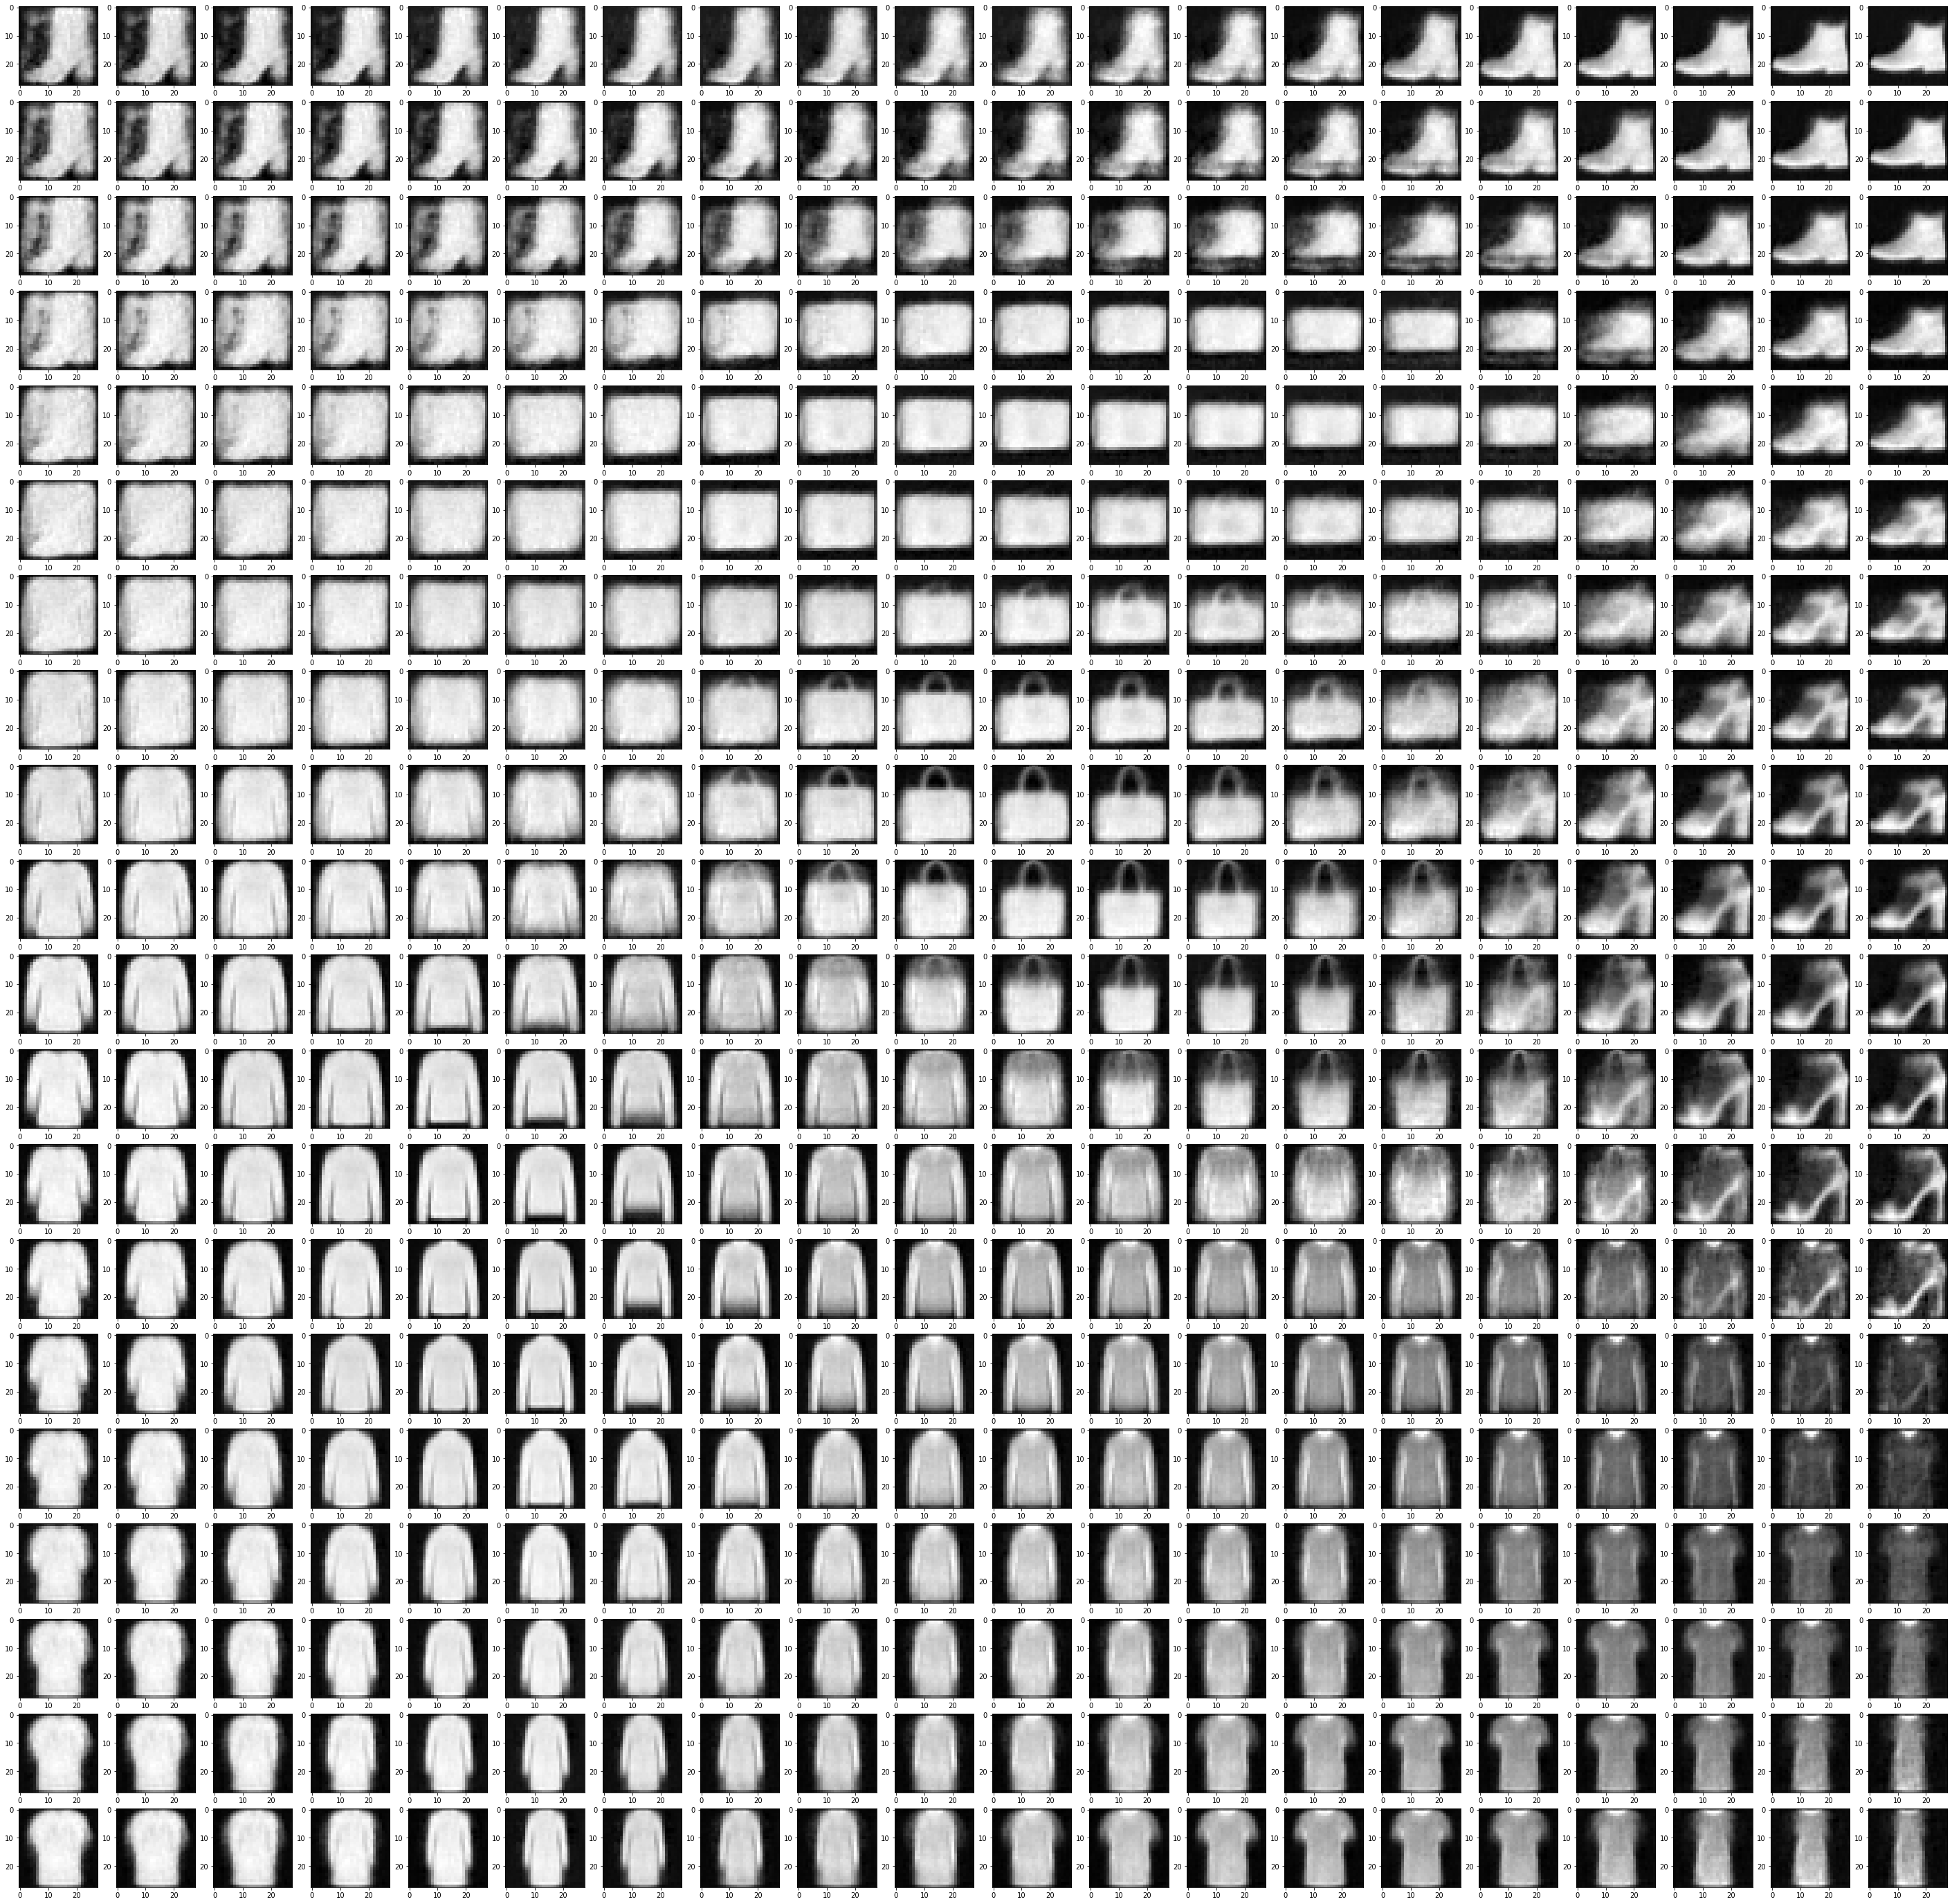

In [18]:
sampled_img.shape
plt.figure(figsize=(50,50))
sampled_img += 0.5
for i in np.arange(400):
    plt.subplot(20,20,i+1)
    plt.imshow(np.reshape(sampled_img[i],(28,28)),cmap='gray')